In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2


In [2]:
import sys


sys.path.append('../model')

from data import FinData

In [3]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

from sklearn.neighbors import NearestNeighbors

from datetime import datetime

In [56]:
data = FinData("../datasets/T_yandex_10min.csv")


In [5]:
data.df

,utc,open,close,high,low,volume,direction_binary
0,2018-03-07 18:40:00,2375.0,2379.5,2379.5,2375.0,231,1
1,2018-03-07 18:50:00,2380.0,2385.0,2385.0,2380.0,514,1
2,2018-03-07 19:00:00,2385.5,2388.0,2388.0,2384.0,226,1
3,2018-03-07 19:10:00,2388.0,2389.5,2389.5,2387.0,207,0
4,2018-03-07 19:20:00,2386.5,2386.0,2389.0,2386.0,25,0
...,...,...,...,...,...,...,...
134444,2024-12-06 20:00:00,3379.5,3384.0,3384.5,3379.5,741,0
134445,2024-12-06 20:10:00,3383.5,3382.5,3383.5,3382.5,563,0
134446,2024-12-06 20:20:00,3382.0,3378.5,3382.0,3378.0,1449,0
134447,2024-12-06 20:30:00,3378.5,3366.5,3380.0,3351.0,8532,1


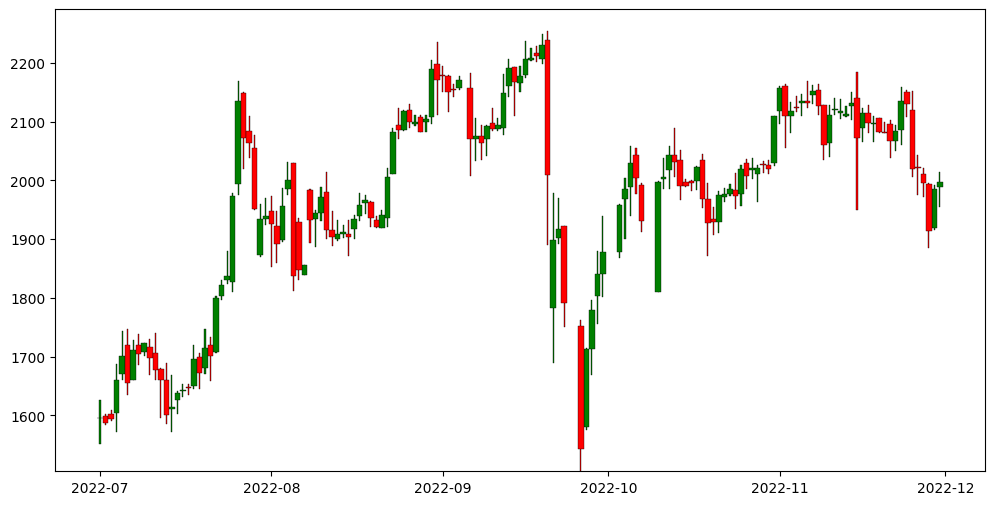

In [7]:
data.visualize_time_frame(datetime(2022, 7, 1), datetime(2022, 12, 1), candle_freq='1d', cmap='cool', line_kwargs={'linewidth': 1.5})

Количество соседей $ k $ в методе k-ближайших соседей (KNN) существенно влияет на производительность и точность алгоритма. Вот основные аспекты, на которые это влияет:

### **1. Чувствительность к шуму**
- **Маленькое значение $ k $**: Если $ k $ равно 1, алгоритм будет очень чувствителен к шуму в данных. Один выброс или аномалия могут значительно изменить классификацию, так как решение будет основываться только на ближайшем соседе
- **Большое значение $ k $**: Увеличение $ k $ может сгладить влияние шумовых данных, так как учитываются множественные соседи. Однако это может привести к потере локальной структуры данных и сглаживанию границ между классами

### **2. Балансировка классов**
- В задачах с дисбалансом классов выбор четного значения $ k $ может привести к неоднозначности в голосовании, когда количество соседей из разных классов будет одинаковым. Рекомендуется использовать нечетные значения для предотвращения таких ситуаций

### **3. Обобщающая способность**
- **Низкое значение $ k $**: Модель может переобучаться, так как она слишком точно подстраивается под обучающие данные, что приводит к плохой обобщающей способности на новых данных.
- **Высокое значение $ k $**: Это может привести к недообучению, когда модель становится слишком общей и не способна уловить важные закономерности в данных.

### **4. Вычислительные затраты**
- Увеличение $ k $ также увеличивает вычислительные затраты, так как алгоритму нужно рассчитать расстояния до большего числа соседей. Это может быть критично при работе с большими наборами данных


Выбор оптимального значения $ k $ является важным шагом в процессе настройки модели k-NN. Обычно рекомендуется использовать методы кросс-валидации для определения наилучшего значения, которое обеспечит баланс между чувствительностью к шуму и обобщающей способностью модели.


In [70]:
def knn_gaps(k = 3, m = 6):
    data = FinData("../datasets/T_yandex_10min.csv")
    ts = (data.df['close'] / data.df['open']).to_numpy()
    
    X = []
    for i in range(len(ts) - m):
        X.append(ts[i:i + m])
    X = np.array(X)

    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)
    mean_distances = distances.mean(axis=1)
    threshold = np.percentile(mean_distances, 95)
    # выбросы
    outlier_indices = np.where(mean_distances > threshold)[0]
    normal_indices = np.where(mean_distances <= threshold)[0]
    
    print('Clean data')
    data.df = data.df.iloc[normal_indices]
    data.visualize_time_frame(datetime(2022, 7, 1), datetime(2022, 12, 1), candle_freq='1d', cmap='cool', line_kwargs={'linewidth': 1.5})
    plt.show()
    data.df['direction'] = data.df['close']/data.df['open']
    print(data.df.describe()['direction'])

    print('\n\nOutlier data')
    data = FinData("../datasets/T_yandex_10min.csv")
    data.df = data.df.iloc[outlier_indices]
    data.visualize_time_frame(datetime(2022, 7, 1), datetime(2022, 12, 1), candle_freq='1d', cmap='cool', line_kwargs={'linewidth': 1.5})
    plt.show()
    data.df['direction'] = data.df['close']/data.df['open']
    print(data.df.describe()['direction'])
    data = FinData("../datasets/T_yandex_10min.csv")



Clean data


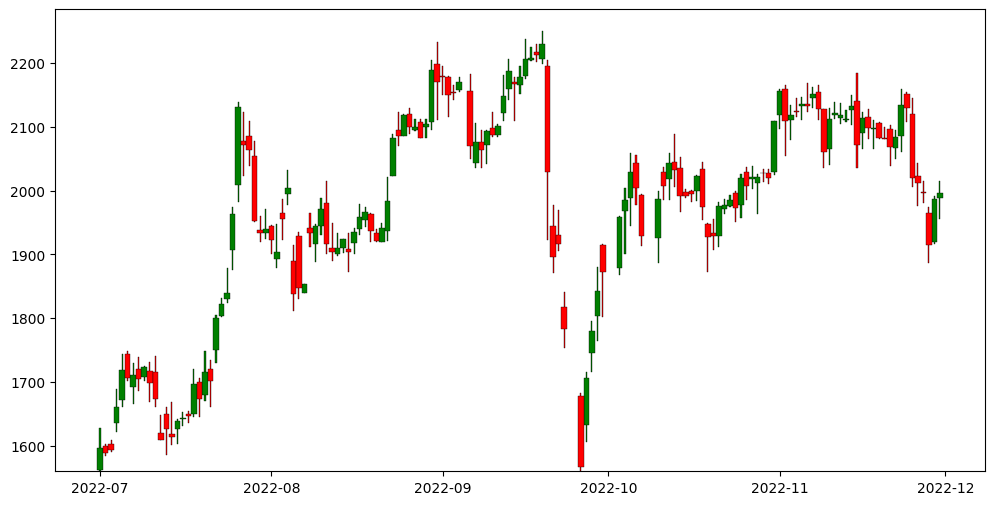

count    127720.000000
mean          1.000012
min           0.983208
25%           0.999098
50%           1.000000
75%           1.000918
max           1.016333
std           0.002236
Name: direction, dtype: float64


Outlier data


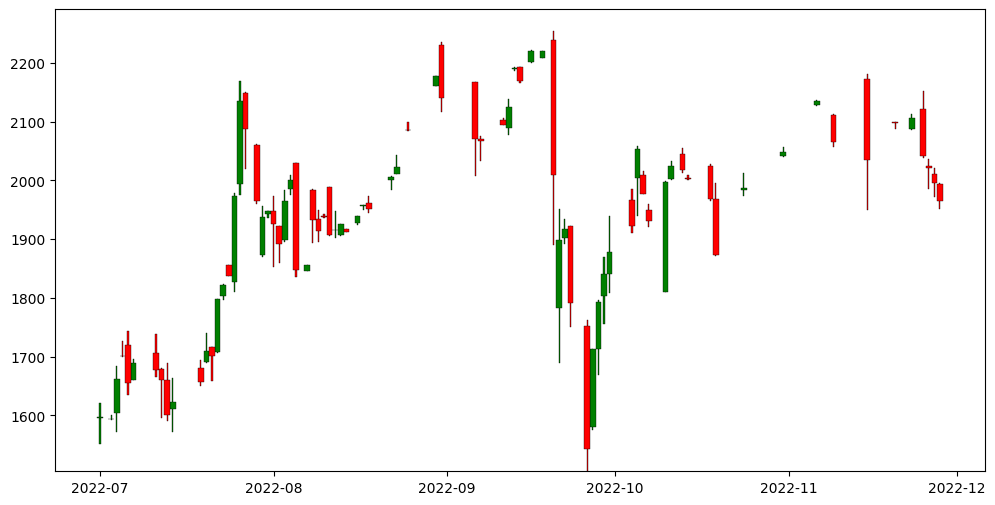

count    6723.000000
mean        0.999839
min         0.767434
25%         0.994666
50%         1.000000
75%         1.004923
max         1.203397
std         0.010790
Name: direction, dtype: float64


In [71]:
knn_gaps(3, 6)

Clean data


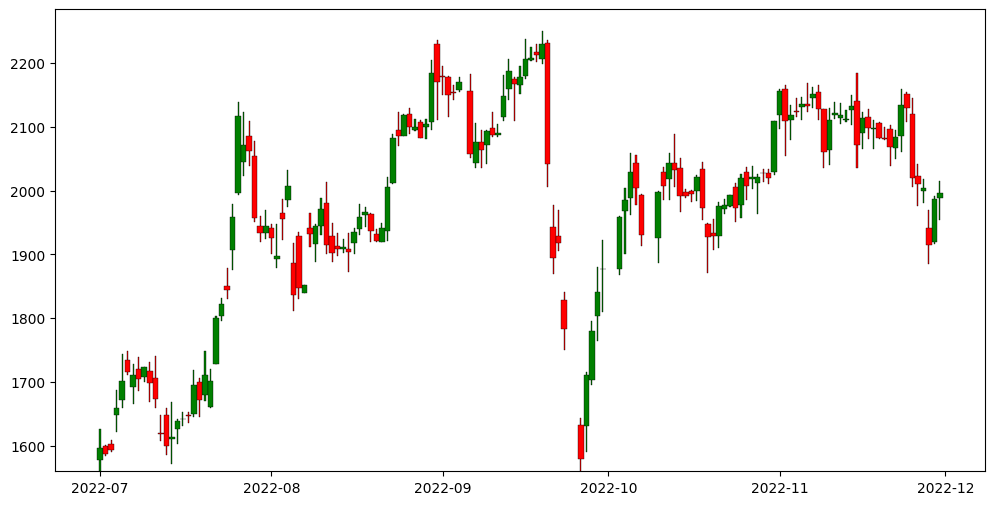

count    127719.000000
mean          1.000015
min           0.982432
25%           0.999096
50%           1.000000
75%           1.000922
max           1.020669
std           0.002275
Name: direction, dtype: float64


Outlier data


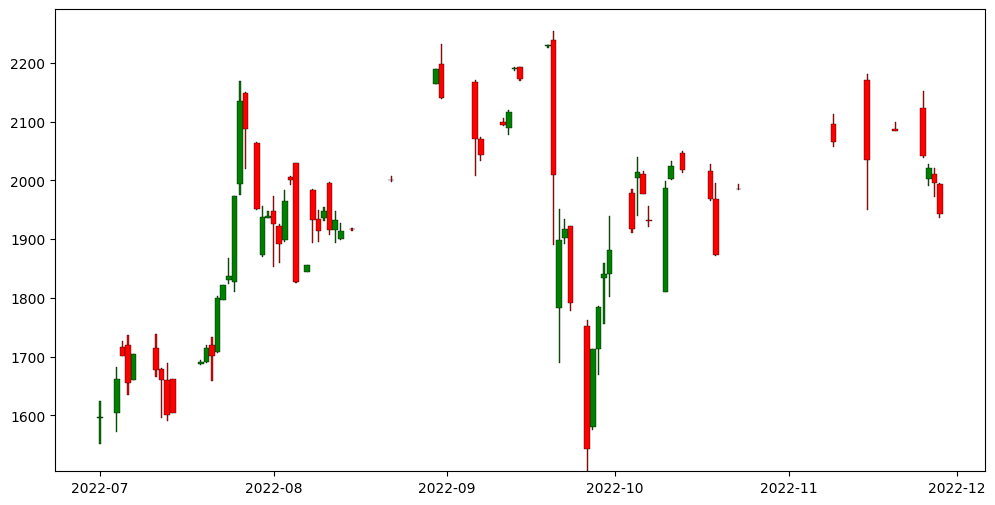

count    6722.000000
mean        0.999792
min         0.767434
25%         0.994938
50%         1.000000
75%         1.004563
max         1.203397
std         0.010634
Name: direction, dtype: float64


In [72]:
knn_gaps(2, 8)

Clean data


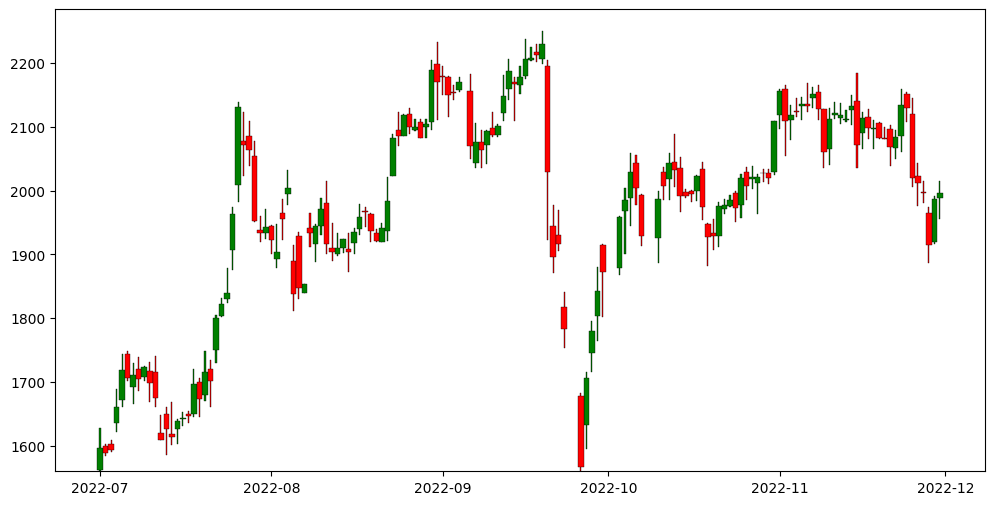

count    127720.000000
mean          1.000011
min           0.983208
25%           0.999097
50%           1.000000
75%           1.000918
max           1.016650
std           0.002233
Name: direction, dtype: float64


Outlier data


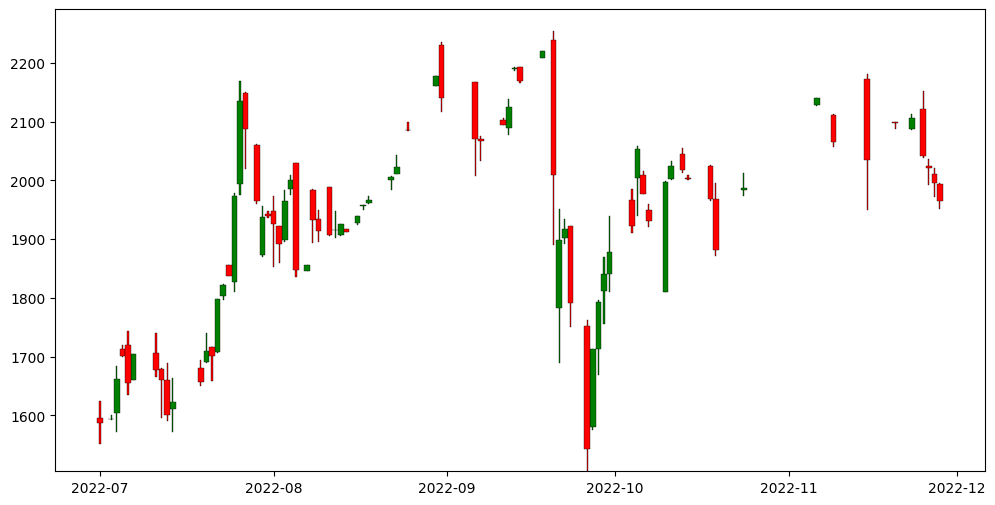

count    6723.000000
mean        0.999872
min         0.767434
25%         0.994692
50%         1.000000
75%         1.005003
max         1.203397
std         0.010805
Name: direction, dtype: float64


In [73]:
knn_gaps(4, 6)

Clean data


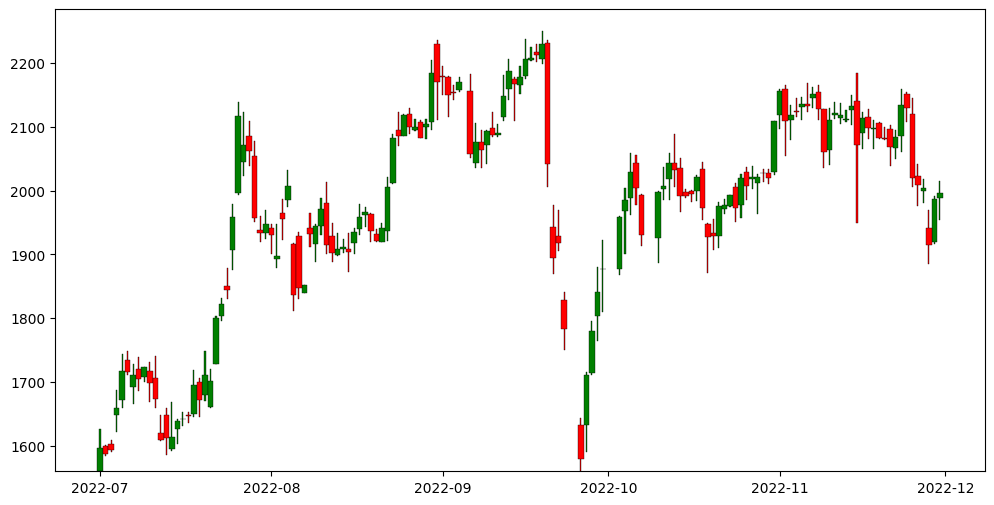

count    127719.000000
mean          1.000013
min           0.982759
25%           0.999096
50%           1.000000
75%           1.000921
max           1.020669
std           0.002267
Name: direction, dtype: float64


Outlier data


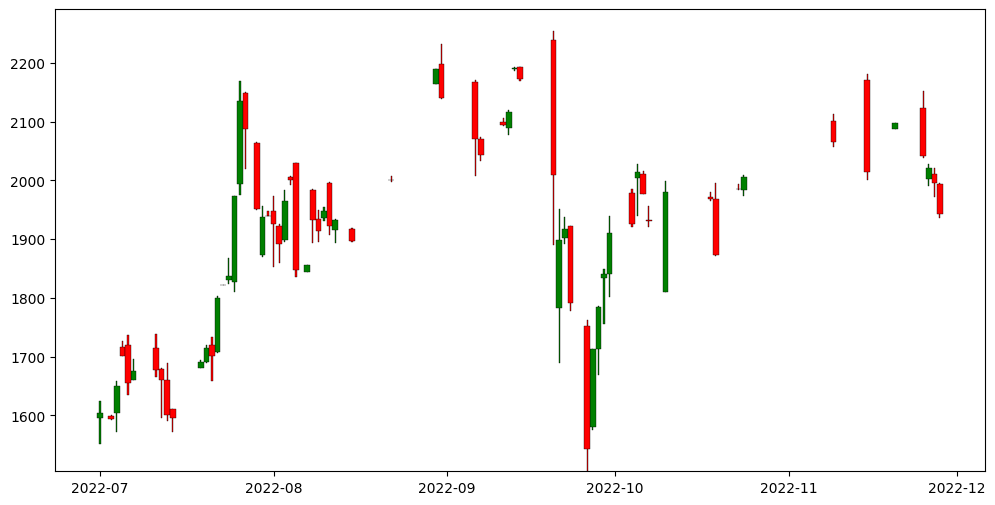

count    6722.000000
mean        0.999834
min         0.767434
25%         0.994871
50%         1.000000
75%         1.004764
max         1.203397
std         0.010669
Name: direction, dtype: float64


In [74]:
knn_gaps(4, 8)